In [13]:
import csv
import string
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as mplcm
import matplotlib as mpl
import scipy
import math
import copy
import os
from datetime import datetime
import random
import multiprocessing
import pickle

import bioscrape as bs
import bioscrape.lineage as bs_lineage

# rc={'lines.linewidth': 2, 'axes.labelsize': 14, 'axes.titlesize': 14}
# sns.set(rc=rc)
# sns.set(style = "ticks")

sns.set_context('paper')

%matplotlib inline
#%config InlineBackend.figure_f.ormats=['svg']
color_list = ['r', 'k', 'b','g','y','m','c']
mpl.rc('axes', prop_cycle=(mpl.cycler('color', color_list) ))
mpl.rc('xtick', labelsize=12) 
mpl.rc('ytick', labelsize=12)

# Utility functions

In [14]:
def simulate_with_caching(cache_filename, **turbidostat_args):
    '''Wraps simulate_turbidostat_models, but memoizes the results in a file 
    cached_results/<cache_filename>. If that cache file exists, then the model in it 
    will be used instead of running the simulation again. Delete the cache file to
    run the simulation fresh. 
    '''
    if cache_filename is None:
        results = bs_lineage.py_SimulateTurbidostat(return_dataframes = False, 
                                                    return_sample_times = False,
                                                    **turbidostat_args)
        return results
    full_cache_filename = os.path.join('cached_results', cache_filename)
    if os.path.isfile(full_cache_filename):
        print(f"Using cached results from file {full_cache_filename}.")
        results = pickle.load(open(full_cache_filename, 'rb'))
    else:
        results = bs_lineage.py_SimulateTurbidostat(return_dataframes = False, 
                                                    return_sample_times = False,
                                                    **turbidostat_args)
        pickle.dump(results, open(full_cache_filename, 'wb'))
    return results

In [15]:
# Color cycling nonsense
import pylab

In [16]:
def discretize_fade_colormap(cmap, min_c, max_c, N):
    '''
    Convert a range [min_c, max_c] of a continuous colormap cmap 
    into a discrete colormap with N values.
    
    Code modified from https://scipy-cookbook.readthedocs.io/
    items/Matplotlib_ColormapTransformations.html
    '''
    colors_i = np.concatenate((np.linspace(min_c, max_c, N), (0.,0.,0.,0.)))
    colors_rgba = cmap(colors_i)
    indices = np.linspace(0,1, N+1)
    cdict = {}
    for ki, key in enumerate(('red','green','blue')):
        cdict[key] = [(indices[i], colors_rgba[i-1,ki], colors_rgba[i,ki]) \
                      for i in range(N+1)]
    # Return colormap object.
    return colors.LinearSegmentedColormap(None, cdict, 1024)

In [17]:
def make_colors_and_colorbar(colormap, values, label = None, labelsize = 15):
    '''
    Create an index-indexable discrete version of a colormap 
    and plot an appropriate colorbar over a range of values.
    
    colormap - the base colormap.
    values - values that will be shown with the colormap.
    label - string labeling what those values are.
    labelsize - how big you want the label (passed to ax.set_title()).
    
    Returns: A list of colors, indexable by the indexes of values.
    '''
    color_idxs = np.linspace(0, 1, len(values))
    discrete_colormap = discretize_fade_colormap(colormap, 0, 
                                               1.0, len(values))
    indexable_discrete_colormap = [discrete_colormap(i) for i in color_idxs]
    
    green_sm = plt.cm.ScalarMappable(cmap=discrete_colormap, 
                                 norm=plt.Normalize(vmin=values[0], vmax=values[-1]))
    cbar  = plt.colorbar(green_sm)
    lp = 0
    values_int = (max(values) - min(values)) / (len(values))
    values_midpoints = [values_int*i + values_int/2 + min(values) for i in range(len(values))]
    values_labels = [f"{value:.2f}" for value in values]
    cbar.ax.set_title(label, size = 15, y = 1.02)
    cbar.set_ticks(values_midpoints)
    cbar.set_ticklabels(values_labels)
    
    return indexable_discrete_colormap

# The temporal logic gate...

Here's a temporal logic gate of similar form to the one in Hsiao *et al* 2016 (https://doi.org/10.15252/msb.20156663). In its original form, the logic gate used a single genome-integrated reporter module. 

Important parameters are, in units of nM and hours:
* $k_{leakA}, k_{leakB}$: Production of integrases when no signal present (leak).
* $k_{txA}, k_{txB}$: Production of integrases when signal present
* $t_A, t_B$: Times at which signals *sigA* and *sigB* appear, respectively.
* $k_{bind}, k_{unbind}$: Rates of association and dissociation, respectively, between integrase monomers and DNA. 
* $k_{flip}$: Rate at which a DNA with four integrase monomers attached will change states. 

In [18]:
# Units of nM and 1/hr. Values taken from table S1 of Hsiao et al. 2016,
# as revised in that paper in section "Varying model parameters for integrase activity 
# and basal expression" (see Fig. S13).
default_TLG_params = {
    "k_txA": 50,
    "k_txB": 50,
    "k_bind": 100,
    "k_unbind": 1000, # based on measured k_D of ~10, assumed faster than anything else.
    "k_flipA": 0.2,
    "k_flipB": 0.3,
    "k_gamma": 0.3 # Corresponds to a cell division time around ~1 hour.
}
default_TLG_params['k_leakA'] = 0.01 * default_TLG_params['k_txA']
default_TLG_params['k_leakB'] = 0.02 * default_TLG_params['k_txB']

First, we can simulate that using a single-copy, non-replicating DNA with a partitioning rule that duplicates it exactly on division. To do this, we'll hae to use a quasisteady state approximation for integrase binding (puzzle for the user: how would you implement DNA duplication with explicit integrase binding?).

In [19]:
# Makes a temporal logic circuit lineage model with rule-based, instant
# DNA replication at division time, using quasisteady state approximation
# for integrase binding.
def make_genomic_temporal_logic_gate(params, initial_conditions):
    rxns = []
    # Int = integrase, sig = signal molecule, dS = DNA in state S
    species = ["IntA", "IntB", "sigA", "sigB", "dO", "dA", "dB", "dAB"]
    rules = [] # Using rules to control signal appearance.
    
    # Integrase production.
    for x in ["A", "B"]:
        rxns.append([[], [f"Int{x}"], 'general', {'rate': f"k_leak{x} + k_tx{x}*Heaviside(sig{x}-1)"}])
        
    # Signal control of integrase expression - transcription is a little leaky, and 
    # switches on as soon as signal appears. Signal starts at 0 and appears according
    # to parameters t_A and t_B.
    # Transcription goes from 
    rules = [("assignment", {"equation":f"sig{x} = Heaviside(t-t_{x})"}) for x in ['A', 'B']]
    
    # DNA state changes, following transition function from Hsiao et al 2016.
    kd = "(k_unbind/k_bind)"
    def n(x, i):
        '''Makes a string of the form "IntX * (IntX-1) * (IntX-2) * ..." up
        through "... * (IntX-i)".'''
        s = f"Int{x}"
        for j in range(1,i+1):
            s += f" * (Int{x}-{j})"
        return s
    
    def equilibrium_int(x):
        return f"{n(x,3)} / ({kd}^4 + {n(x,0)}*{kd}^3 + {n(x,1)}*{kd}^2 + {n(x,2)}*{kd} + {n(x,3)})"
    
    def flip_rate(x, init_state):
        return f"k_flip{x} * d{init_state} * {equilibrium_int(x)}"
    
    rxns.append([["dO"], ["dA"], 'general', {'rate': flip_rate('A', 'O')}])
    rxns.append([["dA"], ["dAB"], 'general', {'rate': flip_rate('B', 'A')}])
    rxns.append([["dO"], ["dB"], 'general', {'rate': flip_rate('B', 'O')}])
    
    m = bs_lineage.LineageModel(reactions = rxns, 
                                parameters = params,
                                species = species,
                                rules = rules,
                                initial_condition_dict = initial_conditions)

    # Multiplicative growth with rate set by k_gamma, but don't grow if there's 
    # no DNA present. 
    m.create_volume_rule("ode", {"equation": "volume * k_gamma"})

    # Divide when volume doubles (to 2), splitting all species binomially, with a small amount
    # of noise in volume partitioning.
    vsplit = bs_lineage.LineageVolumeSplitter(m, 
              options = {"default": "binomial", "dO": "duplicate", "dA": "duplicate", 
                         "dB": "duplicate", "dAB": "duplicate"},
              partition_noise = 0.05)
    division_vol = 2
    m.create_division_rule("volume", {"threshold":division_vol}, vsplit)

    m.py_initialize()
    return m

In [20]:
initial_conditions = {
    'dO': 1,
    'dA': 0,
    'dB': 0,
    'dAB': 0,
    'IntA': 0,
    'IntB': 0
}
norep_TLG_params = copy.deepcopy(default_TLG_params)
norep_TLG_params['t_A'] = 2
norep_TLG_params['t_B'] = 10

norep_TLG_model = make_genomic_temporal_logic_gate(norep_TLG_params, initial_conditions)
max_t = 30
ts = np.linspace(0, max_t, 1000)
sample_ts = np.linspace(0, max_t, 30)

start_time = datetime.now()
max_pop = 1056
norep_TLG_results = simulate_with_caching(None,#'temporal_gate_norep.pkl',
                                          initial_cell_states = max_pop, 
                                          timepoints = ts,
                                          sample_times = sample_ts,
                                          population_cap = max_pop,
                                          Model = norep_TLG_model)   
end_time = datetime.now()
print(f"Execution time: {end_time - start_time}")

Execution time: 0:00:10.482348


In [117]:
state_colors = {
    "O": "black",
    "A": "red",
    "B": "blue",
    "AB": "purple"
}

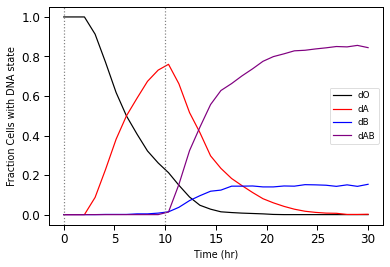

In [119]:
norep_time_slices = [time_slice for time_slice in norep_TLG_results]
norep_sample_times = [t_slice[0].py_get_time() for t_slice in norep_time_slices]
norep_dna_totals = dict()

for s in ['dO', 'dA', 'dB', 'dAB']:
    s_idx = norep_TLG_model.get_species2index()[f'{s}']
    norep_dna_totals[s] = \
        [sum([cs.py_get_state()[s_idx] for cs in t_slice])/len(t_slice) \
         for t_slice in norep_time_slices]
    plt.plot(norep_sample_times, norep_dna_totals[s], label = f"{s}", color = state_colors[s[1:]])

plt.axvline(norep_TLG_params['t_A'], color = "gray", ls = ":")
plt.axvline(norep_TLG_params['t_B'], color = "gray", ls = ":")
# plt.plot(norep_sample_times, [len(t_slice)/max_pop for t_slice in norep_time_slices], 
#          color = 'gray', lw=1, ls=":", label = "# Cells (normalized)")
plt.xlabel("Time (hr)")
plt.ylabel("Fraction Cells with DNA state")
plt.legend()
plt.show()

Reproducing figure 3a from Hsiao et al:

In [23]:
tBs = np.linspace(0, 10, 11)
fig3a_results = [None] * len(tBs)
initial_conditions = {
    'dO': 1,
    'dA': 0,
    'dB': 0,
    'dAB': 0,
    'IntA': 0,
    'IntB': 0
}
max_pop = 1024

for i, tB in enumerate(tBs):
    norep_TLG_params = copy.deepcopy(default_TLG_params)
    norep_TLG_params['t_A'] = 0
    norep_TLG_params['t_B'] = tB

    norep_TLG_model = make_genomic_temporal_logic_gate(norep_TLG_params, initial_conditions)
    max_t = 30
    ts = np.linspace(0, max_t, 1000)
    sample_ts = np.linspace(0, max_t, 30)

    start_time = datetime.now()
    max_pop = 1056
    fig3a_results[i] = simulate_with_caching(f'temporal_gate_norep_{tB}.pkl',
                                              initial_cell_states = max_pop, 
                                              timepoints = ts,
                                              sample_times = sample_ts,
                                              population_cap = max_pop,
                                              Model = norep_TLG_model)   
    end_time = datetime.now()
    print(f"Execution time: {end_time - start_time}")

Execution time: 0:00:13.344465
Execution time: 0:00:11.081016
Execution time: 0:00:10.620781
Execution time: 0:00:09.384458
Execution time: 0:00:09.345406
Execution time: 0:00:09.369835
Execution time: 0:00:09.114957
Execution time: 0:00:09.092069
Execution time: 0:00:08.954562
Execution time: 0:00:08.539070
Execution time: 0:00:08.771342


<ipython-input-187-62c5b283f39e>:15: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  plt.show()


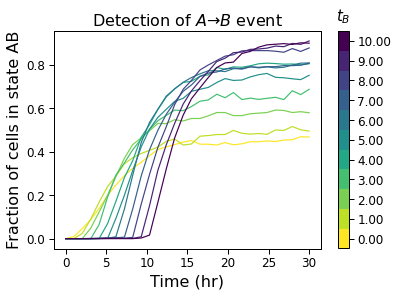

In [187]:
indexable_colors = make_colors_and_colorbar(pylab.get_cmap('viridis_r'), tBs, r"$t_B$")
for i, tB in enumerate(tBs):
    results = fig3a_results[i]
    time_slices = [time_slice for time_slice in results]
    sample_times = [t_slice[0].py_get_time() for t_slice in time_slices]
    s_idx = norep_TLG_model.get_species2index()['dAB']
    dna_totals = \
        [sum([cs.py_get_state()[s_idx] for cs in t_slice])/len(t_slice) \
         for t_slice in time_slices]
    plt.plot(sample_times, dna_totals, label = f"tB = {tB}", color = indexable_colors[i])

plt.title(r"Detection of $A\to B$ event", fontsize = 16)
plt.xlabel("Time (hr)", fontsize = 16)
plt.ylabel("Fraction of cells in state AB", fontsize = 16)
plt.show()

# ...on a plasmid

Now we can make an equivalent circuit on a plasmid. Notice that now, because our plasmids are real species with modeled kinetics, we can dispense with the steady-state binding assumption from the genomic model. 

In [25]:
def dna_complex(s, x, y, prefix = "DNA"):
    '''
    Make a string describing a DNA in plasmid state prefix and 
    integration state s, bound by x IntA and y IntB.
    '''
    return f"{prefix}_{s}_A{x}_B{y}"

In [91]:
# Add the core temporal logic circuit reactions and integrase binding to 
# a replication mechanism specified by a list of species and reactions.
def make_logic_gate_from_replication_base(params, initial_conditions, rep_species, rep_rxns):
    dna_species = [s for s in rep_species if s.startswith("DNA")] # Base DNA names, need to be
                                                                  # replaced with complex names.
    species = [x for x in rep_species if not x.startswith("DNA")] # All other species, which will
                                                                  # stay the same.
    species += ["IntA", "IntB", "sigA", "sigB"] # Int = integrase, sig = signal molecule.
    rules = [] # Using rules to control signal appearance.
    rxns = []
    
    # Integrase functions as a tetramer, with each integrase subunit binding independently.
    # Denote a DNA species with DNA state D, integrase state S in {O, A, B, AB}, bound by 
    # x IntA integrases and y IntB integrases as "D_S_Ax_By".
    for s in ["O", "A", "B", "AB"]:
        for x in range(5):
            for y in range(5):
                for d in dna_species:
                    species.append(dna_complex(s, x, y, d))
                    
    # Update replication reactions with integrases bound.
    for reaction in rep_rxns:
        reactants, products, rxn_type, param_dict = reaction
        dna_in_reactants = len([x for x in reactants if x.startswith("DNA")]) > 0
        dna_in_products  = len([x for x in products if x.startswith("DNA")]) > 0
        if dna_in_reactants or dna_in_products:
            for s in ["O", "A", "B", "AB"]:
                for x in range(5):
                    for y in range(5):
                        if x == 0 and y == 0:
                            continue
                        bound_reacts = [dna_complex(s, x, y, d) if d in dna_species else d for d in reactants]
                        bound_prods = [dna_complex(s, x, y, d) if d in dna_species else d for d in products]
                        rxns.append((bound_reacts, bound_prods, rxn_type, param_dict))
        else:
            rxns.append(reaction)
    
    # Integrase production.
    for char in ["A", "B"]:
        rxns.append(([], [f"Int{char}"], 'general', 
                     {'rate': f"k_leak{char} + k_tx{char}*Heaviside(sig{char}-1)"}))
    
    # Signal control of integrase expression - transcription is a little leaky, and 
    # switches on as soon as signal appears. Signal starts at 0 and appears according
    # to parameters t_A and t_B.
    # Transcription goes from k_leak_x to k_s
    for char in ['A', 'B']:
        rules.append(("assignment", {"equation":f"sig{char} = Heaviside(t-t_{char})"}))
    
    # Integrase binding/unbinding
    for d in dna_species:
        for s in ["O", "A", "B", "AB"]:
            for x in range(5):
                for y in range(5):
                    if x<4: # Bind an A
                        rxns.append(([dna_complex(s, x, y, d), "IntA"], [dna_complex(s, x+1, y, d)], 
                                     'massaction', {'k': params['k_bind']}))
                    if x>0: # Unbind an A
                        rxns.append(([dna_complex(s, x, y, d)], [dna_complex(s, x-1, y, d), "IntA"], 
                                     'massaction', {'k': params['k_unbind']}))
                    if y<4: # Bind a B
                        rxns.append(([dna_complex(s, x, y, d), "IntB"], [dna_complex(s, x, y+1, d)], 
                                     'massaction', {'k': params['k_bind']}))
                    if y>0: # Unbind a B
                        rxns.append(([dna_complex(s, x, y, d)], [dna_complex(s, x, y-1, d), "IntB"], 
                                     'massaction', {'k': params['k_unbind']}))
    # DNA state changes
    for d in dna_species:
        for y in range(5):
            rxns.append(([dna_complex("O", 4, y, d)], [dna_complex("A", 4, y, d)], 
                         'massaction', {'k': params['k_flipA']}))
        for x in range(5):
            rxns.append(([dna_complex("O", x, 4, d)], [dna_complex("B", x, 4, d)],
                         'massaction', {'k': params['k_flipB']}))
            rxns.append(([dna_complex("A", x, 4, d)], [dna_complex("AB", x, 4, d)],
                         'massaction', {'k': params['k_flipB']}))
                        
    return species, rxns, rules

In [92]:
# This will always be for a lineage simulation, so no explicit dilution.
def make_dummy_temporal_logic_gate(params, initial_conditions):
    # Replication module
    species = ["DNA", "R"]
    rxns = []

    rxns.append(([], ["R"], 'massaction', {'k': initial_conditions["DNA_O_A0_B0"]*params['k_gamma']}))
    rxns.append((["DNA", "R"], ["DNA", "DNA"], 'massaction', {'k': 10*params['k_gamma']}))
        
    # Add temporal logic gate core functionality
    species, rxns, rules = make_logic_gate_from_replication_base(params, initial_conditions,
                                                                 species, rxns)
    
    # Turn it into a model.
    m = bs_lineage.LineageModel(reactions = rxns, 
                                parameters = params,
                                species = species,
                                rules = rules,
                                initial_condition_dict = initial_conditions)

    # Multiplicative growth with rate set by k_gamma, no selection (for speed). 
    m.create_volume_rule("ode", {"equation": "volume * k_gamma"})

    # Divide when volume doubles (to 2), splitting all species binomially, with a small amount
    # of noise in volume partitioning.
    vsplit = bs_lineage.LineageVolumeSplitter(m, 
              options = {"default": "binomial", },
              partition_noise = 0.05)
    division_vol = 2
    m.create_division_rule("volume", {"threshold":division_vol}, vsplit)

    m.py_initialize()
    return m

Warning! This may take hours to run uncached.

In [105]:
dummy_inits = {
    'DNA_O_A0_B0': 30,
    'IntA': 0,
    'IntB': 0
}
dummy_TLG_params = copy.deepcopy(default_TLG_params)
dummy_TLG_params['t_A'] = 2
dummy_TLG_params['t_B'] = 10

dummy_TLG_model = make_dummy_temporal_logic_gate(dummy_TLG_params, dummy_inits)
max_t = 30
ts = np.linspace(0, max_t, 1000)
sample_ts = np.linspace(0, max_t, 30)

start_time = datetime.now()
max_pop = 1056
dummy_TLG_results = simulate_with_caching('temporal_gate_dummy.pkl',
                                          initial_cell_states = max_pop, 
                                          timepoints = ts,
                                          sample_times = sample_ts,
                                          population_cap = max_pop,
                                          Model = dummy_TLG_model)   
end_time = datetime.now()
print(f"Execution time: {end_time - start_time}")

Execution time: 5:13:42.603836


<ipython-input-185-7d3cffcfc839>:33: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  plt.show()


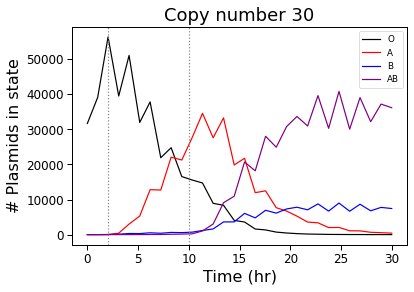

In [185]:
def plot_TLG_plasmid_totals(results, params, model, title = None):
    time_slices = [time_slice for time_slice in results]
    sample_times = [t_slice[0].py_get_time() for t_slice in time_slices]
    dna_totals = dict()

    # For convenience, map out the indexes of every DNA species with each state.
    dna_idxs = dict()
    for state in ['O', 'A', 'B', 'AB']:
        dna_idxs[state] = []
    species_map = model.get_species2index()
    for s, idx in species_map.items():
        if not s.startswith("DNA"):
            continue
        s_parts = s.split("_")
        dna_idxs[s_parts[1]].append(idx)

    for s in ['O', 'A', 'B', 'AB']:
        dna_totals[s] = \
            [sum([cs.py_get_state()[s_idx] for cs in t_slice for s_idx in dna_idxs[s]]) \
             for t_slice in time_slices]
        plt.plot(sample_times, dna_totals[s], label = f"{s}", color = state_colors[s])

    plt.axvline(params['t_A'], color = "gray", ls = ":")
    plt.axvline(params['t_B'], color = "gray", ls = ":")

    if title is None:
        plt.title("Plasmid-Based Temporal Logic Gate, Total Counts", fontsize = 18)
    else:
        plt.title(title, fontsize = 18)
    plt.xlabel("Time (hr)", fontsize = 16)
    plt.ylabel("# Plasmids in state", fontsize = 16)
    plt.legend()
    plt.show()
    
plot_TLG_plasmid_totals(dummy_TLG_results, dummy_TLG_params, dummy_TLG_model, title = "Copy number 30")

We see here that a population of plasmid-TLG-bearing cells roughly recapitulates the results of a population of genomic-TLG-bearing cells, though perhaps more noisily. 

What do individual cell trajectories look like? We can't pick out any single lineage's dynamics, since lineage information isn't tracked using SimulateTurbidostat, but we can still look at the *spreads* in single-cell state distributions, with a state-dependent rightward shift + jittering on the time axis to make them visible. Tickmarks have been added to the 1st, 25th, 50th, 75th, and 99th percentile for each distribution at each time.

<ipython-input-186-a2f2a9864de4>:48: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  plt.show()


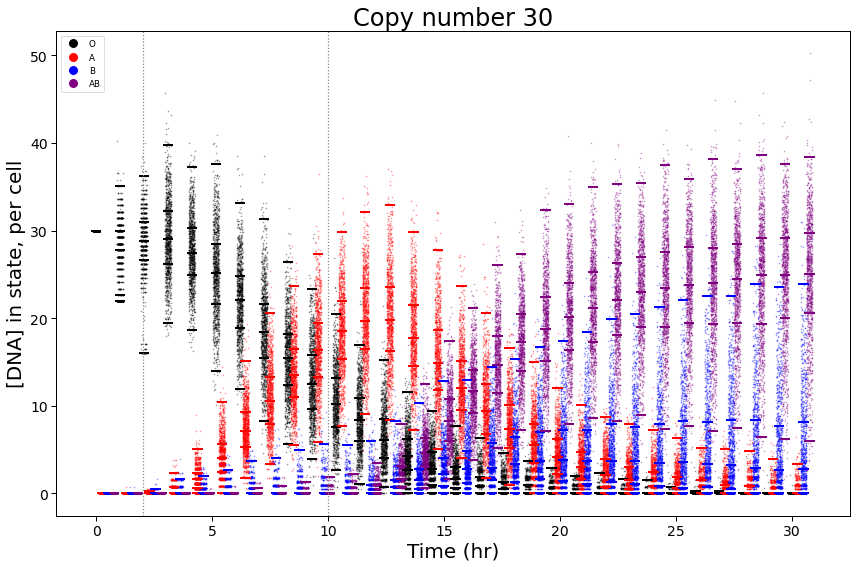

In [186]:
def plot_TLG_distributions(results, params, model, title = None):
    time_slices = [time_slice for time_slice in results]
    
    # For convenience, map out the indexes of every DNA species with each state.
    dna_idxs = dict()
    for state in ['O', 'A', 'B', 'AB']:
        dna_idxs[state] = []
    species_map = model.get_species2index()
    for s, idx in species_map.items():
        if not s.startswith("DNA"):
            continue
        s_parts = s.split("_")
        dna_idxs[s_parts[1]].append(idx)
        
    plt.figure(figsize = (12,8))
    dt = time_slices[1][0].py_get_time() - time_slices[0][0].py_get_time()
    percentiles_to_plot = [1, 25, 50, 75, 99]
    for i, t_slice in enumerate(time_slices):
        ts = t_slice[0].py_get_time() * np.ones(len(t_slice))
        for j, s in enumerate(['O', 'A', 'B', 'AB']):
            temp_dna_totals = [sum([cs.py_get_state()[s_idx] for s_idx in dna_idxs[s]])/cs.py_get_volume() \
                               for cs in t_slice]
            plt.scatter(ts + j*dt/4 + (np.random.rand(len(ts))-.5)*dt/4, temp_dna_totals, 
                        label = f"{s}" if i==0 else None, color = state_colors[s], s = 1, alpha = 0.25)
            percentile_vals = np.percentile(temp_dna_totals, percentiles_to_plot).T
            tick_endpoints = [ts[0] + (j-.7)*dt/4, ts[0] + (j+.7)*dt/4]
            xmesh, ymesh = np.meshgrid(tick_endpoints, percentile_vals, indexing = "ij")
            plt.plot(xmesh, ymesh, color = state_colors[s], lw = 2)

    plt.axvline(params['t_A'], color = "gray", ls = ":")
    plt.axvline(params['t_B'], color = "gray", ls = ":")

    if title is None:
        plt.title("Plasmid-based Temporal Logic Gate, Single-Cell Distributions", fontsize = 24)
    else:
        plt.title(title, fontsize = 24)
    plt.xlabel("Time (hr)", fontsize = 20)
    plt.ylabel("[DNA] in state, per cell", fontsize = 20)
    plt.xticks(fontsize = 14)
    plt.yticks(fontsize = 14)
    legend_elements = [mpl.lines.Line2D([0],[0], marker = 'o', color = 'w', 
                                               markerfacecolor = state_colors[s], 
                                               markersize = 10, label = s)\
                       for s in state_colors.keys()]
    plt.legend(handles = legend_elements)

    plt.tight_layout()
    plt.show()

plot_TLG_distributions(dummy_TLG_results, dummy_TLG_params, dummy_TLG_model, title = "Copy number 30")

From this, it looks like a 30-copy plasmid version of the temporal logic gate comes with a great deal of noise, but the middle 50% of copy number distributions (per state) is clustered reasonably tightly.

What does the same thing look like for a higher copy number? 

In [182]:
large_dummy_inits = {
    'DNA_O_A0_B0': 100,
    'IntA': 0,
    'IntB': 0
}
large_dummy_TLG_params = copy.deepcopy(default_TLG_params)
large_dummy_TLG_params['t_A'] = 2
large_dummy_TLG_params['t_B'] = 10

large_dummy_TLG_model = make_dummy_temporal_logic_gate(large_dummy_TLG_params, large_dummy_inits)
max_t = 30
ts = np.linspace(0, max_t, 1000)
sample_ts = np.linspace(0, max_t, 30)

start_time = datetime.now()
max_pop = 1056
large_dummy_TLG_results = simulate_with_caching('temporal_gate_high_copy_dummy.pkl',
                                          initial_cell_states = max_pop, 
                                          timepoints = ts,
                                          sample_times = sample_ts,
                                          population_cap = max_pop,
                                          Model = large_dummy_TLG_model)   
end_time = datetime.now()
print(f"Execution time: {end_time - start_time}")

Execution time: 17:08:50.703109


<ipython-input-169-62d8eb987861>:33: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  plt.show()
<ipython-input-170-ff961017b8ac>:48: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  plt.show()


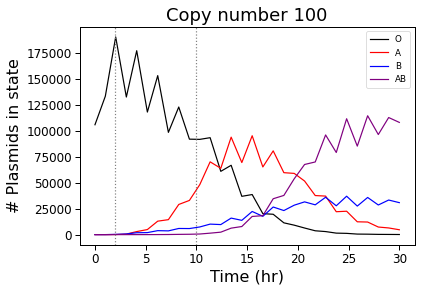

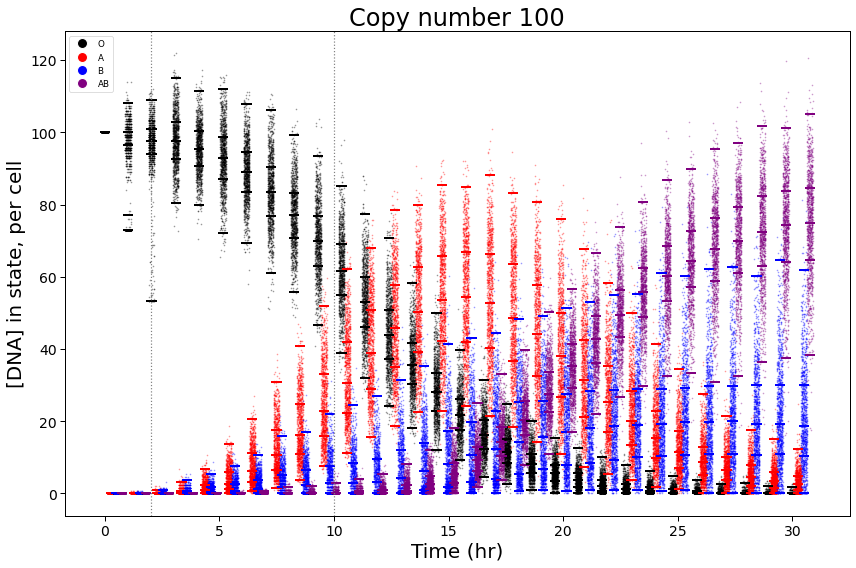

In [184]:
plot_TLG_plasmid_totals(large_dummy_TLG_results, large_dummy_TLG_params, large_dummy_TLG_model, title = "Copy number 100")
plot_TLG_distributions(large_dummy_TLG_results, large_dummy_TLG_params, large_dummy_TLG_model, "Copy number 100")